# Building custom maze 

1. **Define Generator**: You can define your own maze generator, simply generate a two dimensional numpy array consisting of objects labeled by integers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

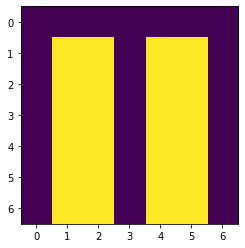

In [2]:
# Spatial alternation task
x = np.array([[0, 0, 0, 0, 0, 0, 0], 
              [0, 1, 1, 0, 1, 1, 0], 
              [0, 1, 1, 0, 1, 1, 0], 
              [0, 1, 1, 0, 1, 1, 0], 
              [0, 1, 1, 0, 1, 1, 0], 
              [0, 1, 1, 0, 1, 1, 0],
              [0, 1, 1, 0, 1, 1, 0]])
start_idx = [[6, 3]]
goal_idx = [[6, 0]]
env_id = 'SpatialAlteration-v0'

plt.imshow(x)

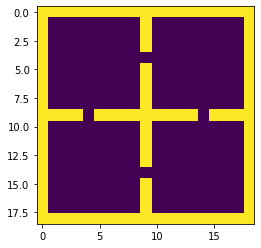

In [3]:
# Four room task
x = np.array([np.ones(19),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),                                    
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([np.ones(4), [0],  np.ones(9), [0], np.ones(4)]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.ones(19)])
start_idx = [[4, 4]]
goal_idx = [[14, 14]]
env_id = 'FourRoom-v0'

plt.imshow(x)

2. **Subclass BaseMaze**: Define your own maze by creating all Object and their properties

In [4]:
import numpy as np
from mazelab import BaseMaze
from mazelab import Object
from mazelab import DeepMindColor as color


class Maze(BaseMaze):
    @property
    def size(self):
        return x.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(x == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(x == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

3. **Define Motion**: Define your own motion or simply use the one we provided: VonNeumannMotion, MooreMotion
4. **Define gym environment**: Subclass the BaseEnv to define the gym environment.

In [5]:
from mazelab import BaseEnv
from mazelab import VonNeumannMotion

import gym
from gym.spaces import Box
from gym.spaces import Discrete


class Env(BaseEnv):
    def __init__(self):
        super().__init__()
        
        self.maze = Maze()
        self.motions = VonNeumannMotion()
        
        self.observation_space = Box(low=0, high=len(self.maze.objects), shape=self.maze.size, dtype=np.uint8)
        self.action_space = Discrete(len(self.motions))
        
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        if valid:
            self.maze.objects.agent.positions = [new_position]
        
        if self._is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
        return self.maze.to_value(), reward, done, {}
        
    def reset(self):
        self.maze.objects.agent.positions = start_idx
        self.maze.objects.goal.positions = goal_idx
        return self.maze.to_value()
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        out = False
        for pos in self.maze.objects.goal.positions:
            if position[0] == pos[0] and position[1] == pos[1]:
                out = True
                break
        return out
    
    def get_image(self):
        return self.maze.to_rgb()

5. **Register environment**: It is recommended to register your own environment to allow easy-to-use gym.make

In [6]:
env_id = 'FourRoom-v0'
gym.envs.register(id=env_id, entry_point=Env, max_episode_steps=200)

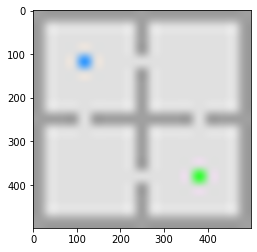

In [7]:
env = gym.make(env_id)
env.reset()
img = env.render('rgb_array')
plt.imshow(img)

6. **Build-in Dijkstra solver**: For simple goal-reaching environment, one could use the build-in Dijkstra solver to compute the optimal action sequences given the current agent position and goal position.

In [9]:
from mazelab.solvers import dijkstra_solver

impassable_array = env.unwrapped.maze.to_impassable()
motions = env.unwrapped.motions
start = env.unwrapped.maze.objects.agent.positions[0]
goal = env.unwrapped.maze.objects.goal.positions[0]
actions = dijkstra_solver(impassable_array, motions, start, goal)
print(actions)
env = gym.wrappers.Monitor(env, './', force=True)
rewards = 0.0
env.reset()
for action in actions:
    _, reward, _, _ = env.step(action)
    rewards += reward
env.close()
print(rewards)

[1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\48786\\Documents\\GitHub\\maze-generator\\.ipynb_checkpoints\\openaigym.video.0.25064.video000000.mp4'

7.  **Record video** of executing optimal actions

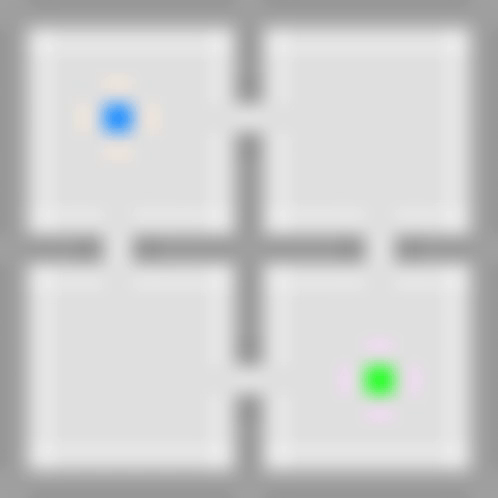

In [13]:
import imageio
from IPython.display import Image
from pathlib import Path
f = list(Path('./').glob('*.mp4'))[0]
reader = imageio.get_reader(f)
f = f'./{env_id}.gif'
with imageio.get_writer(f, fps=3) as writer:
    [writer.append_data(img) for img in reader]
Image(f)

In [12]:
f = open('C:/Users/48786/Documents/GitHub/graph_navig/mazes/3.txt', 'r')
maze_txt = f.read()
print(maze_txt)

1,1,1,1,1,1,1,1,1,1,1,1,1,1
0,1,0,1,1,0,0,0,1,0,1,1,0,0
0,1,0,0,1,1,0,0,1,0,0,1,1,0
1,0,0,1,1,0,1,1,0,0,1,1,0,1
0,1,0,1,1,0,0,0,1,0,1,1,0,0
0,0,0,1,1,0,1,0,0,0,1,1,0,1
0,0,0,0,1,0,1,0,0,0,0,1,0,1
1,1,1,1,1,1,0,0,1,1,1,1,1,1
0,1,0,1,1,0,0,0,1,0,1,1,0,0
0,1,0,0,1,1,0,0,1,0,0,1,1,0
1,0,0,1,1,0,1,1,0,0,1,1,0,1
0,1,0,1,1,0,0,0,1,0,1,1,0,0
0,0,0,1,1,0,1,0,0,0,1,1,0,1
0,0,0,0,1,0,1,0,0,0,0,1,0,1


In [13]:
maze_lst = []
for i in maze_txt:
    if i == "1":
        maze_lst.append(1)
    elif i == "0":
        maze_lst.append(0)
    else:
        continue
print(len(maze_lst))

196


In [14]:
import numpy as np

In [15]:
maze = np.array(maze_lst)
maze = maze.reshape(14, 14)
maze

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]])

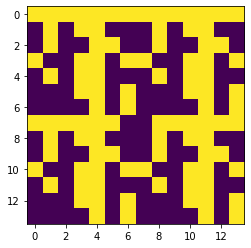

In [17]:
import matplotlib.pyplot as plt

plt.imshow(maze)

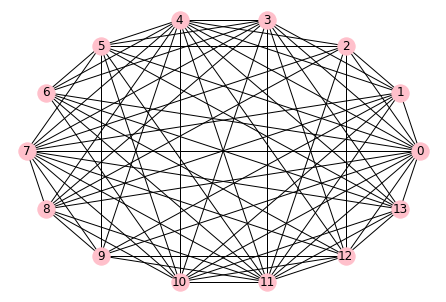

In [40]:
import networkx as nx

G = nx.from_numpy_array(maze)
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=nx.circular_layout(G), node_color="pink")

In [57]:
mapping = {k:"N{}".format(k+1) for k in G.nodes()}
G1 = nx.relabel_nodes(G, mapping)

In [59]:
def numpy_to_nx(adj, node_features=None, edge_features=None, nf_name=None,
                ef_name=None):
    """
    Converts graphs in numpy format to a list of nx.Graphs.
    :param adj: adjacency matrices of shape `(num_samples, num_nodes, num_nodes)`.
    If there is only one sample, the first dimension can be dropped.
    :param node_features: optional node attributes matrices of shape `(num_samples, num_nodes, node_features_dim)`.
    If there is only one sample, the first dimension can be dropped.
    :param edge_features: optional edge attributes matrices of shape `(num_samples, num_nodes, num_nodes, edge_features_dim)`
    If there is only one sample, the first dimension can be dropped.
    :param nf_name: optional name to assign to node attributes in the nx.Graphs
    :param ef_name: optional name to assign to edge attributes in the nx.Graphs
    :return: a list of nx.Graphs (or a single nx.Graph is there is only one sample)
    """
    if adj.ndim == 2:
        adj = adj[None, ...]
        if node_features is not None:
            if nf_name is None:
                nf_name = 'node_features'
            node_features = node_features[None, ...]
            if node_features.ndim != 3:
                raise ValueError('node_features must have shape (batch, N, F) '
                                 'or (N, F).')
        if edge_features is not None:
            if ef_name is None:
                ef_name = 'edge_features'
            edge_features = edge_features[None, ...]
            if edge_features.ndim != 4:
                raise ValueError('edge_features must have shape (batch, N, N, S) '
                                 'or (N, N, S).')

    output = []
    for i in range(adj.shape[0]):
        g = nx.from_numpy_array(adj[i])
        g.remove_nodes_from(list(nx.isolates(g)))

        if node_features is not None:
            node_attrs = {n: {nf_name: node_features[i, n]} for n in g.nodes}
            nx.set_node_attributes(g, node_attrs, nf_name)
        if edge_features is not None:
            edge_attrs = {e: {ef_name: edge_features[i, e[0], e[1]]} for e in g.edges}
            nx.set_edge_attributes(g, edge_attrs, ef_name)
        output.append(g)

    if len(output) == 1:
        return output[0]
    else:
        return output 

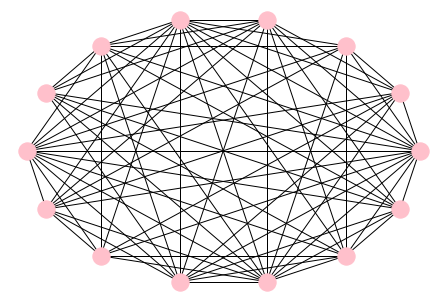

In [69]:
output = numpy_to_nx(maze)

nx.draw(output, pos=nx.circular_layout(output), node_color="pink")

In [64]:
def get_lcc(graph, return_inds=False):
    r"""
    Finds the largest connected component for the input graph.

    The largest connected component is the fully connected subgraph
    which has the most nodes.

    Parameters
    ----------
    graph: nx.Graph, nx.DiGraph, nx.MultiDiGraph, nx.MultiGraph, np.ndarray
        Input graph in any of the above specified formats. If np.ndarray,
        interpreted as an :math:`n \times n` adjacency matrix

    return_inds: boolean, default: False
        Whether to return a np.ndarray containing the indices in the original
        adjacency matrix that were kept and are now in the returned graph.
        Ignored when input is networkx object

    Returns
    -------
    graph: nx.Graph, nx.DiGraph, nx.MultiDiGraph, nx.MultiGraph, np.ndarray
        New graph of the largest connected component of the input parameter.

    inds: (optional)
        Indices from the original adjacency matrix that were kept after taking
        the largest connected component.
    """
    input_ndarray = False
    if type(graph) is np.ndarray:
        input_ndarray = True
        if is_symmetric(graph):
            g_object = nx.Graph()
        else:
            g_object = nx.DiGraph()
        graph = nx.from_numpy_array(graph, create_using=g_object)
    if type(graph) in [nx.Graph, nx.MultiGraph]:
        lcc_nodes = max(nx.connected_components(graph), key=len)
    elif type(graph) in [nx.DiGraph, nx.MultiDiGraph]:
        lcc_nodes = max(nx.weakly_connected_components(graph), key=len)
    lcc = graph.subgraph(lcc_nodes).copy()
    lcc.remove_nodes_from([n for n in lcc if n not in lcc_nodes])
    if return_inds:
        nodelist = np.array(list(lcc_nodes))
    if input_ndarray:
        lcc = nx.to_numpy_array(lcc)
    if return_inds:
        return lcc, nodelist
    return lcc 

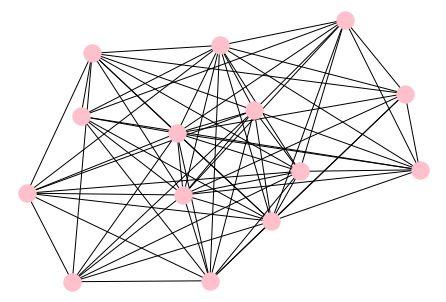

In [68]:
lcc = get_lcc(output)

nx.draw(lcc, node_color="pink")

In [58]:
import plotly
from plotly import graph_objects as go

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]
    x1, y1 = G.nodes[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

ValueError: not enough values to unpack (expected 2, got 0)

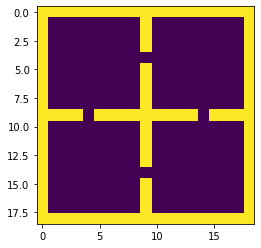

In [21]:
x = np.array([np.ones(19),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),                                    
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([np.ones(4), [0],  np.ones(9), [0], np.ones(4)]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [0], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.concatenate([[1], np.zeros(8), [1], np.zeros(8), [1]]),
              np.ones(19)])

plt.imshow(x)

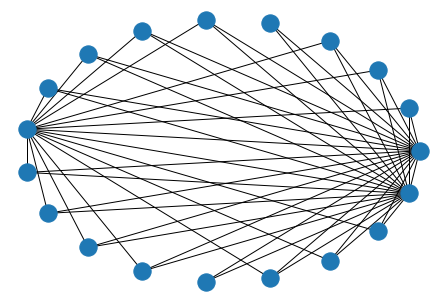

In [38]:
F = nx.from_numpy_array(x)
nx.draw(F, nx.circular_layout(F))

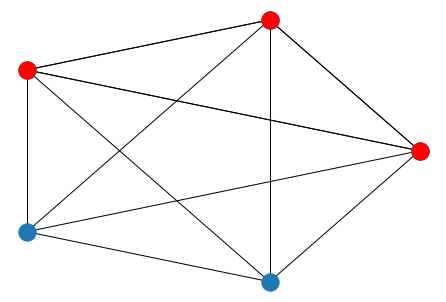

In [23]:

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos)  # Draw the original graph
# Draw a subgraph, reusing the same node positions
nx.draw(G.subgraph([0, 1, 2]), pos=pos, node_color="red")